### Model Referred from: https://github.com/Breta01/handwriting-ocr/blob/master/notebooks/page_detection.ipynb

#### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = (9.0, 9.0)

#### Load Files

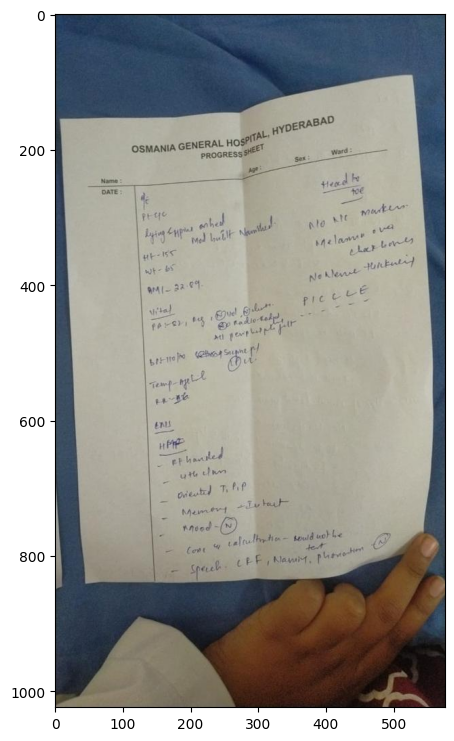

In [3]:
#Load image without any modifications
file_name = "Records/Arthritis/A_0005.jpeg" 
image = cv2.imread(filename=file_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

#### Convert to Potrait

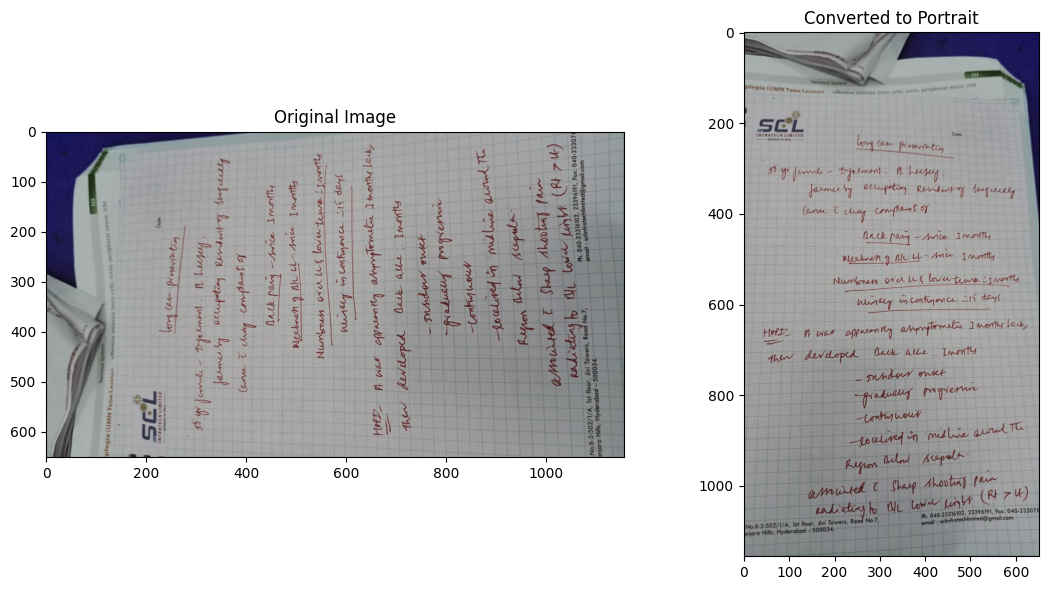

In [4]:
def convert_to_portrait(image):
    height, width, _ = image.shape

    if width > height:
        transposed_image = cv2.transpose(image)
        portrait_image = cv2.flip(transposed_image, 1)
        return portrait_image
    else:
        return image
f = "Records/backpain/BP_0001.jpg"
img = cv2.imread(f)
img1 = convert_to_portrait(img)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img)
axes[0].set_title('Original Image')

axes[1].imshow(img1)
axes[1].set_title('Converted to Portrait')

plt.tight_layout()
plt.show()

#### Canny Edge Detection

In [5]:
def resize_image(image,height=800):
    if (image.shape[0] > height):
        rat = height / image.shape[0]
        image_temp =cv2.resize(image, (int(rat * image.shape[1]), height))
    else:
        image_temp = image
    return image_temp
def edge_detection(image,mn=200,mx=250,height=800):
    image_temp = resize_image(image)
    image_gray = cv2.cvtColor(image_temp, cv2.COLOR_BGR2GRAY)
    
    image_blur = cv2.bilateralFilter(image_gray, 9, 75, 75)
    
    image_th = cv2.adaptiveThreshold(image_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    #plt.imshow(image_th,cmap ='gray')
    
    image_med = cv2.medianBlur(image_th, 11)
    
    image_border = cv2.copyMakeBorder(image_med, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    #plt.imshow(image_border, 'gray')
    
    return cv2.Canny(image_border, mn, mx)

#### Extract Contours

In [6]:
def get_contour(image):
    binary_image = edge_detection(image)
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # print(len(contours))
    print(contours)
    contour_img = cv2.drawContours(resize_image(image),contours,-1,(0,255,0),thickness=2,lineType=cv2.LINE_AA)
    return contour_img

(array([[[334, 797]],

       [[333, 798]],

       [[332, 798]],

       [[331, 799]],

       [[330, 799]],

       [[329, 800]],

       [[328, 800]],

       [[327, 801]],

       [[327, 802]],

       [[326, 803]],

       [[326, 804]],

       [[326, 803]],

       [[330, 799]],

       [[331, 799]],

       [[332, 798]],

       [[333, 798]],

       [[334, 797]],

       [[335, 797]],

       [[336, 798]],

       [[337, 798]],

       [[340, 801]],

       [[340, 803]],

       [[339, 804]],

       [[328, 804]],

       [[340, 804]],

       [[340, 801]],

       [[339, 800]],

       [[339, 799]],

       [[338, 799]],

       [[337, 798]],

       [[336, 798]],

       [[335, 797]]], dtype=int32), array([[[400, 762]],

       [[399, 763]],

       [[397, 763]],

       [[396, 764]],

       [[395, 764]],

       [[394, 765]],

       [[393, 765]],

       [[389, 769]],

       [[389, 770]],

       [[388, 771]],

       [[388, 774]],

       [[387, 775]],

       [[387, 778

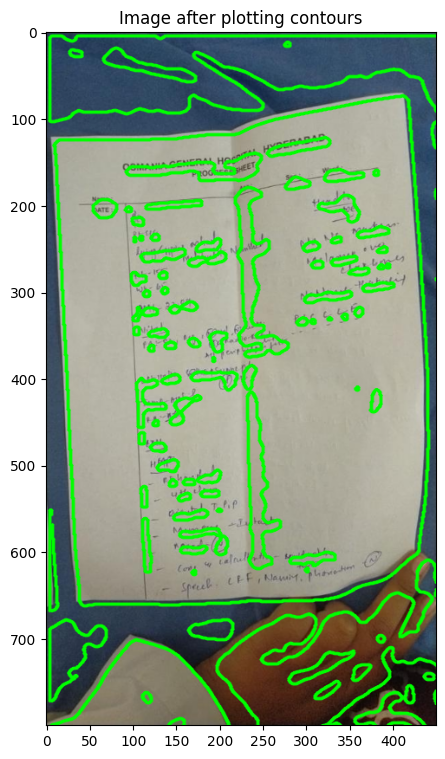

In [7]:
plt.title('Image after plotting contours')
plt.imshow(get_contour(image));

#### Connect Corners and remove Edges

In [8]:
def four_corners_sort(pts):
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def contour_offset(cnt, offset):
    cnt += offset
    cnt[cnt < 0] = 0
    return cnt


def find_page_contours(edges, img):
    # Getting contours  
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding biggest rectangle otherwise return original corners
    height = edges.shape[0]
    width = edges.shape[1]
    MIN_COUNTOUR_AREA = height * width * 0.5
    MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

    max_area = MIN_COUNTOUR_AREA
    page_contour = np.array([[0, 0],
                            [0, height-5],
                            [width-5, height-5],
                            [width-5, 0]])

    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4 and
                cv2.isContourConvex(approx) and
                max_area < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
            
            max_area = cv2.contourArea(approx)
            page_contour = approx[:, 0]

    # Sort corners and offset them
    page_contour = four_corners_sort(page_contour)
    return contour_offset(page_contour, (-5, -5))

In [9]:
small = resize_image(image)
# Edge detection ()
edges_image = edge_detection(small, 200, 250)

# Close gaps between edges (double page clouse => rectangle kernel)
edges_image = cv2.morphologyEx(edges_image, cv2.MORPH_CLOSE, np.ones((5, 11)))

In [10]:
page_contour = find_page_contours(edges_image, small)
print("PAGE CONTOUR:")
print(page_contour)
       
# Recalculate to original scale
page_contour = page_contour.dot(image.shape[0]/small.shape[0])

PAGE CONTOUR:
[[  5 123]
 [ 36 656]
 [425 594]
 [409  69]]


#### Final Transform

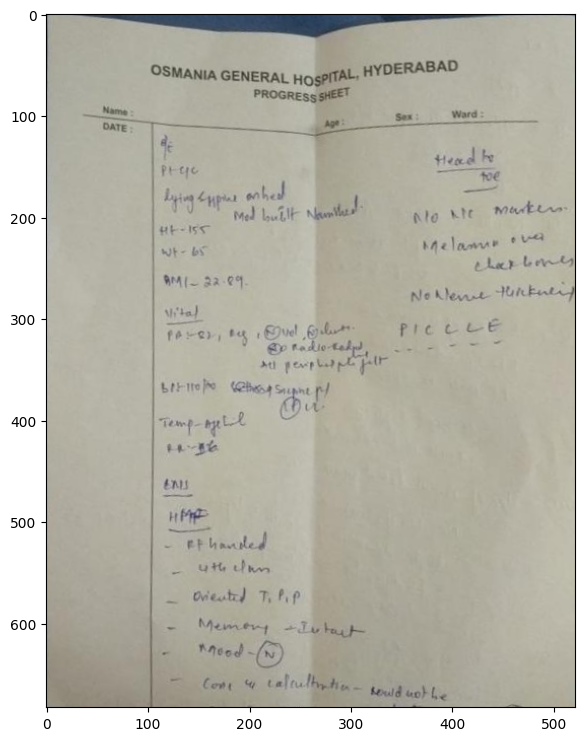

In [11]:
def persp_transform(img, s_points):
    """ Transform perspective from start points to target points """
    # Euclidean distance - calculate maximum height and width
    height = max(np.linalg.norm(s_points[0] - s_points[1]),
                 np.linalg.norm(s_points[2] - s_points[3]))
    width = max(np.linalg.norm(s_points[1] - s_points[2]),
                 np.linalg.norm(s_points[3] - s_points[0]))
    
    # Create target points
    t_points = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if s_points.dtype != np.float32:
        s_points = s_points.astype(np.float32)
    
    M = cv2.getPerspectiveTransform(s_points, t_points) 
    return cv2.warpPerspective(img, M, (int(width), int(height)))
    
    
newImage = persp_transform(image, page_contour)
plt.imshow(newImage);